<a href="https://colab.research.google.com/github/juneilsam/Deokso_el_pred/blob/main/DS_el_lstm_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np # 넘파이
import pandas as pd
from math import sqrt # math
from tqdm import tqdm

from matplotlib import pyplot # 플롯을 그리기 위함
from pandas import read_csv # csv 파일 읽기
from pandas import DataFrame # dataframe 활용을 위함
from pandas import concat # dataframe 병합을 위함
from pandas import to_datetime, to_timedelta, date_range
from sklearn.preprocessing import MinMaxScaler # 최대최소 스케일러
from sklearn.metrics import mean_squared_error # mse
from sklearn.metrics import r2_score # r2

#tensorflow 2.0
from tensorflow.keras.models import Sequential, load_model # 시퀀스 모델을 사용하기 위함
from tensorflow.keras.layers import Dense, Dropout # Dense, Dropout을 사용하기 위함
from tensorflow.keras.layers import LSTM # lstm을 사용하기 위함

import joblib # 모델 생성을 위함
import pickle # 모델 생성을 위함
import psycopg2 as pc # 쿼리문 작성을 위함
import os
import csv

In [ ]:
########################################
def elToCSV():
    try:
        conn = pc.connect(database="",user="",password="",host="",port="")
        curs = conn.cursor()

        DS_data = []
        rain_data = []
        DS1 = ["'B001'", "'B002'", "'B003'", "'B004'", "'A001'", "'A002'", "'A003'", "'A004'"]
        DS2 = ["'BH01_A'", "'BH02_A'", "'BH03_A'", "'BH04_A'", "'BH01_B'", "'BH02_B'", "'BH03_B'", "'BH04_B'"]
        for i in range(len(DS1)):
            sql = f"select   gvo.site_code, gvo.site_day, gvo.avg_el, gwo.avg_rain_day \
            from gw_data_value_day gvo left join gw_weather_value_day gwo on gvo.site_day = gwo.site_day\
            where   (gvo.site_code = {DS1[i]} or gvo.site_code = {DS2[i]}) and gvo.m_sn like 'S%1'\
            order by site_day desc"

            df = pd.read_sql(sql, conn)
            df['data_time'] = to_datetime(df['site_day'].astype(str))
            df = df.rename(columns={'site_day':'_date'})
            df.set_index('_date', inplace=True, drop=True)
            df = df.loc[~df.index.duplicated(keep='first')]
            rain_df = DataFrame(df[['avg_rain_day']].values, columns = ['rain_' + str(i+1)], index=df.index)
            df = DataFrame(df[['avg_el']].values, columns = [DS2[i].replace("'", "")], index=df.index)
            DS_data.append(df)
            rain_data.append(rain_df)
            
        DS_data = concat(DS_data, axis=1)
        rain_df = concat(rain_data, axis=1)
        rain_data = DataFrame(rain_df.mean(axis=1), columns=['rain'])
        DS_data = concat((DS_data, rain_data), axis=1)
        DS_data.to_csv("HS_woNaN.csv", encoding='euc-kr', header=True, doublequote=True, sep=',', index=True)
        print("CSV File has been created")
        conn.close()
        
    except:
        print('DB로부터 데이터를 다운로드하는 데 문제가 있습니다.')
    return DS_data

In [ ]:
def CSVToDB():
    try:
        conn = pc.connect(database="",user="",password="",host="",port="")
        curs = conn.cursor()

        curs.execute("DELETE FROM gw_data_value_ai")
        conn.commit()

        copy_sql = """
                   COPY gw_data_value_ai (site_code, data_time, m_sn, el) FROM stdin DELIMITER ',' CSV header
                   """

        with open('pred_result.csv', 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                curs.execute("INSERT INTO gw_data_value_ai (site_code, data_time, m_sn, el) VALUES (%s, %s, %s, %s)", row)

        conn.commit()

        curs.close()
        conn.close()
        print("DB Inserted")
    except:
        print("CSV 파일을 DB에 업로드하는 데 문제가 있습니다.")

In [ ]:
# convert series to supervised learning lstm 사용 위해 시계열 시퀀스 데이터로 변환
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    temp = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1) 시퀀스 데이터 추가하기
    for i in range(n_in, 0, -1):
        cols.append(temp.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n) 시퀀스 예측 데이터 추가하기
    for i in range(0, n_out):
        cols.append(temp.shift(-i)) # 변환, 컬럼 추가
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)] # names에 예측 데이터 i = 0인 경우
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] # names에 예측 데이터

    # put it all together
    agg = concat(cols, axis=1) # 데이터 합치기
    agg.columns = names

    # drop rows with NaN values null값이 있는 행 지우기
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# 실 데이터 예측
def model_predict(act_X):
    for i in range(7):
        zhat = model.predict(act_X) # 예측 데이터 활용한 예측
        act_X[:6,0,0] = act_X[1:7,0,0] # 예측된 데이터를 반영하기 위해 기존 데이터의 행을 변경함
        act_X[-1,0,0] = zhat[-1,0] # 예측된 데이터 추가
    act_X = act_X.reshape((act_X.shape[0], act_X.shape[2]))
    return act_X, zhat

In [ ]:
# 결과값 평가를 위해 
def result_sum(xhat, yhat, train_X, train_y, test_X, test_y):
    # invert scaling for forecast
    inv_xhat = np.concatenate((xhat, train_X[:, 1:]), axis=1)
    inv_xhat = scaler.inverse_transform(inv_xhat)
    inv_xhat = inv_xhat[:,0]
    
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_x = np.concatenate((train_y, train_X[:, 1:]), axis=1)
    inv_x = scaler.inverse_transform(inv_x)
    inv_x = inv_x[:,0]
    
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # 결과 출력
    # calculate RMSE
    trainRMSE = sqrt(mean_squared_error(inv_x, inv_xhat))
    trainR2 = r2_score(inv_x, inv_xhat)
    print('Train RMSE : %.3f' % trainRMSE)
    print('Train R2 : %.3f' % trainR2)
    testRMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
    testR2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE : %.3f' % testRMSE)
    print('Test R2 : %.3f' % testR2)

    # plot baseline and prediction 실제, 예측, 검증 데이터 관련 그래프
    pyplot.plot(inv_y, label='actual')
    pyplot.plot(inv_yhat, label='test')
    pyplot.legend()
    pyplot.show()
    
    return testR2

In [ ]:
def model_fitting(train_X, train_y, test_X, test_y, model):
    # early_stopping
    # early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

    # fit network
    # 모델 적용(학습 횟수(epoch) : 200, 한 번에 학습하는 데이터 개수(batch_size) : 15, 검증 데이터 설정, verbose : 2, shuffle 안함)
    history = model.fit(train_X, train_y, epochs=200, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False) # , callbacks=[early_stop])
    
    # plot history 플롯 설정(훈련, 검증 셋)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # make a prediction 예측하기
    xhat = model.predict(train_X)
    yhat = model.predict(test_X) # 검증 데이터X 예측
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    

    return result_sum(xhat, yhat, train_X, train_y, test_X, test_y), model

In [ ]:
def model_compile(train_X):
# design network 모델 파라미터 설정
    model = Sequential() # 시퀀스 데이터 사용할 모델
    model.add(LSTM(60, activation = 'tanh', input_shape=(train_X.shape[1], train_X.shape[2]))) # lstm모델 설정(층 : 60, 활성함수 : 'tanh', 입력 데이터 형태(input_shape)
    model.add(Dropout(0.5)) # 과적합 방지를 위한 피쳐 드롭아웃 설정(모델의 50%)
    model.add(Dense(1, activation = 'linear')) # dense 설정(활성함수 = 'linear')
    model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae']) # 모델 컴파일(오차함수 : loss, 옵티마이저 = 'adam', 정확도)
    model.summary()
    print('loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: ')
    return model

In [ ]:
def split_data(values):
    trainSize = int(len(values)* 0.8)
    train = values[:trainSize, :]
    test = values[trainSize:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1] # 학습에 사용되는 데이터1, 2 (train[:, -1]가 도출될 수 있도록 하는 데이터와 train[:, -1] 데이터)
    test_X, test_y = test[:, :-1], test[:, -1] # 검증 데이터 (위와 같음)

    # reshape input to be 3D [samples, timesteps, features] 3차원 데이터로 변환
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('train_X :', train_X.shape,
          '\ntrain_y :', train_y.shape,
          '\ntest_X :', test_X.shape,
          '\ntest_y :', test_y.shape)    
    
    model = model_compile(train_X)
    
    return model_fitting(train_X, train_y, test_X, test_y, model)

In [ ]:
def scaling(dataset):
    # ensure all data is float 데이터를 float32로 변환
    values = dataset.astype('float32')
    
    # normalize features 피쳐 normalize
    global scaler
    scaler = MinMaxScaler(feature_range=(0, 1)) # 최대최소 스케일링(0, 1)
    scaled = scaler.fit_transform(values) # 지하수 데이터에 스케일러 적용
    return scaled

In [ ]:
def shift_data(values):
    values = scaling(values)
    # frame as supervised learning 지도 학습 프레임
    reframed = series_to_supervised(values, 1, 1) # series_to_supervised 이용, 프레임 변환
    
    # drop columns we don't want to predict 예측하지 않는 컬럼 삭제
    reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
    display(reframed.head())

    # split into train and test sets
    values = reframed.values
    return split_data(values)

In [ ]:
# 날짜 기준
def term(trans_df):
    date_df = pd.DataFrame()
    for k in trans_df.columns[1:9]:
        _null = [j for j in trans_df[trans_df[k].isnull()].index]
        _data = [i for i in trans_df[trans_df[k].notnull()].index]  

        _start = [trans_df.loc[_data[0], '_date']]
        _finish = []

        for i in _null:
            if i+1 in _data:
                if trans_df.loc[i + 1, '_date'] == _start[0]:
                    pass
                else:
                    _start.append(trans_df.loc[i + 1, '_date'])

            if i-1 in _data:
                _finish.append(trans_df.loc[i - 1, '_date'])

        _finish.append(trans_df.loc[_data[-1], '_date'])

        s_df = pd.DataFrame()
        s_df[f'{k}_start'] = _start
        f_df = pd.DataFrame()
        f_df[f'{k}_finish'] = _finish

        a_df = pd.concat([s_df, f_df], axis=1)

        a_df[f'{k}_term'] = a_df[f'{k}_finish'] - a_df[f'{k}_start']


        for i in a_df.index:
            try:
                null_term = a_df.loc[i + 1, f'{k}_start'] - a_df.loc[i, f'{k}_finish'] - pd.Timedelta('1 days')
                if null_term == np.datetime64:
                    continue
                else:
                    a_df.loc[i, f'{k}_null'] = null_term

            except:
                pass

        date_df = pd.concat([date_df, a_df], axis=1)
            
    return date_df

In [ ]:
def data_read():
    df = pd.read_csv('HS_woNaN.csv', parse_dates=['_date'])
    df.reset_index(drop=True, inplace=True)
    df.sort_values('_date', ascending=True, inplace=True)
    _range = date_range(start = df['_date'][0], end = df['_date'][len(df)-1], freq='1D')
    df.set_index('_date',inplace=True)
    display('df', df)
    df.reindex(_range, fill_value='NA')
    _df = df.copy()
    display('_df', _df)

        # 음의 값 변환
    for i in _df.columns[1:9]:
        if min(_df[i].values) < 0:
            for j in _df[_df[i] < 0].index:
                _df.loc[j, i] = abs(_df.loc[j, i])
        
    return _df

In [ ]:
# ################################
# 시간 단위가 맞지 않을 경우 사용
# ###############################
# def data_read():
#     df = pd.read_csv('HS_woNaN.csv', parse_dates=['_date'])
#     df.reset_index(drop=True, inplace=True)
#     display(df)
#     df.sort_values('_date', ascending=True, inplace=True)
#     display(df['_date'][0])
#     _range = date_range(start = df['_date'][0], end = df['_date'][len(df)-1], freq='10min')
#     df.set_index('_date',inplace=True)
#     display('df', df)
#     df.reindex(_range, fill_value='NA')
#     _df = df.copy()
#     display('_df', _df)

#         # 음의 값 변환
#     for i in _df.columns[1:9]:
#         if min(_df[i].values) < 0:
#             for j in _df[_df[i] < 0].index:
#                 _df.loc[j, i] = abs(_df.loc[j, i])
    
#     trans_df = pd.DataFrame()    
#     trans_df_h = pd.DataFrame()

#     # 1시간 단위로 변환
#     _df['rain'] = _df['rain'].fillna(0)
#     _df.reset_index(drop=False, inplace=True)
#     for j, i in tqdm(enumerate(_df.groupby(by = [_df['_date'].dt.year, _df['_date'].dt.month, _df['_date'].dt.day, _df['_date'].dt.hour]))):
#         trans_df_h.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]) + ' ' + str(i[0][3]).zfill(2), format='%Y-%m-%d %H')
#         for k in _df.columns[1:9]:
#             try:
#                 trans_df_h.loc[j, k] = i[1][k].mean(axis=0)
#             except:
#                 trans_df_h.loc[j, k] = np.nan
#         trans_df_h.loc[j, 'rain'] = sum(i[1]['rain'].values)

#     # 1일 단위로 변환
#     for j, i in tqdm(enumerate(trans_df_h.groupby(by = [trans_df_h._date.dt.year, trans_df_h._date.dt.month, trans_df_h._date.dt.day]))):
#         trans_df.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]), format='%Y-%m-%d')
#         for k in trans_df_h.columns[1:9]:
#             try:
#                 trans_df.loc[j, k] = i[1][k].mean(axis=0)
#             except:
#                 trans_df.loc[j, k] = np.nan
#         trans_df.loc[j, 'rain'] = sum(i[1]['rain'].values)
#     trans_df.set_index('_date', drop=True, inplace=True)
        
#     return trans_df

In [ ]:
# 강수량 데이터 전처리
def rain_data(trans_df):
    rain_data = DataFrame(index=date_range(trans_df.index[-1] + to_timedelta('1d'), periods=7), columns=trans_df.columns)    
    for i in rain_data.columns:
        trans_df[[i]] = trans_df[[i]].interpolate(method='linear')
        rain_data[[i]] = trans_df[i][-1]
    rain7 = pd.concat([trans_df, rain_data])
    rain7 = rain7.astype('float32')
    rain7[['rain']] = rain7[['rain']].interpolate(method='linear')
    rain7 = rain7.iloc[-14:, :]
    return rain7

In [ ]:
# 필요 컬럼만 임시로 저장
def imsi(trans_df, spot, n):
    trans_df = trans_df[['_date', spot, 'rain']][n]
    trans_df = trans_df.interpolate(method='linear')
    trans_df = trans_df.set_index('_date')
    return trans_df

In [ ]:
# 필요한 형태로 데이터 변형
def trans_DB(result_df):
    result_df.index = result_df.index.strftime("%Y%m%d")
    result_df = result_df.reset_index()
    index1 = sorted([str(i) for i in result_df.columns[1:]] * 7)
    index2 = [str(i) for i in result_df[result_df.columns[0]]] * 8
    result_df = DataFrame(result_df.iloc[:, 1:].values.reshape(-1, 1), index=[index1, index2], columns = ['el'])
    result_df['m_sn'] = 'S11'
    result_df = result_df.reset_index()
    result_df.columns = ['site_code', 'data_time', 'el', 'm_sn']
    result_df = result_df[['site_code', 'data_time', 'm_sn', 'el']]

    return result_df

In [ ]:
# start(num) : 0-모델 재생성 1-모델 적용

def start(number):
    elToCSV()
    # csv 파일 읽기
    trans_df = data_read()
    display(trans_df)

    # 모델 재생성
    if number == 0:
        try:
            spot_list = trans_df.columns[:8]
            trans_df = trans_df.reset_index()
            date_df = term(trans_df)
            display(date_df)
            for j in spot_list:
                spot = str(j)
                print('='*7, spot, '='*7)

                # 가장 큰 결측구간을 기준으로 위, 아래 데이터 중 더 긴 기간으로 모델을 만들기 위함
                try:
                    upper = (trans_df._date >= pd.Timestamp(date_df.loc[0, f'{spot}_start'])) & (trans_df._date <= pd.Timestamp((date_df[f'{spot}_finish'][date_df[f'{spot}_null'] == date_df[f'{spot}_null'].max()]).values[0]))
                    lower = (trans_df._date >= pd.Timestamp(date_df.loc[(date_df[f'{spot}_finish'][date_df[f'{spot}_null'] == date_df[f'{spot}_null'].max()].index + 1), f'{spot}_start'].values[0]))

                    if len(trans_df[['_date']][upper]) >= len(trans_df[['_date']][lower]):
                        dataset = imsi(trans_df, spot, upper)
                    elif len(trans_df[['_date']][upper]) < len(trans_df[['_date']][lower]):    
                        dataset = imsi(trans_df, spot, lower)
                except:
                    dataset = imsi(trans_df, spot, (trans_df._date >= pd.Timestamp(date_df.loc[0, f'{spot}_start'])))

                # ensure all data is float 데이터를 float32로 변환
                values = dataset.values
                values = values.astype('float32')

                # normalize features 피쳐 normalize
                global scaler
                scaler = MinMaxScaler(feature_range=(0, 1)) # 최대최소 스케일링(0, 1)
                scaled = scaler.fit_transform(values) # 지하수 데이터에 스케일러 적용

                file_name = 'models/' + 'model' + '_' + spot
                coin = 1
                while True:
                    print(f'{coin}번 째 시도')
                    result, model = shift_data(scaled)
                    if result < 0.9:
                        coin += 1
                        continue
                    else:
                        joblib.dump(scaler, f'{file_name}_scaler.save')
                        print(f"{spot} 스케일러가 저장되었습니다.\n") 
                        model.save(f'{file_name}.h5')
                        print(f"{spot} 모델이 저장되었습니다.\n")
                        break

        except:
            print("모델 생성에 문제가 있습니다.\n")
            
    # 모델 적용            
    elif number == 1:
        try:
            rain7 = rain_data(trans_df)
            result_df = []
            # 모델 불러와서 결과 출력
            for i in rain7.columns[:-1]:
                print(i)
                load_dir = 'models/model_' + str(i)
                scaler = joblib.load(load_dir + '_scaler.save')
                model = load_model(load_dir + '.h5')
                model.summary()

                pred_X = scaler.transform(rain7[[i, 'rain']].values) # 지하수 데이터에 스케일러 적용
                for j in range(7):
                    act_X = pred_X[j:j+7]
                    act_X = act_X.reshape(act_X.shape[0], 1, act_X.shape[1])
                    zhat = model.predict(act_X)
                    pred_X[j+7, 0] = zhat[-1]
                result = DataFrame((scaler.inverse_transform(pred_X))[:, 0], columns = [i], index = rain7.index)

                pyplot.plot(result.values)
                pyplot.axvline(x=6, color='r')
                pyplot.show()

                result_df.append(result)
            result_df = pd.concat(result_df, axis=1).iloc[-7:, :]
            display(result_df)

            result_df = trans_DB(result_df)

            result_df.to_csv('pred_result.csv', encoding='euc-kr', header=True, index=False)
            print("CSV is saved")
            CSVToDB()
            print("Process is finished")
        
        except:
            print("모델 적용에 문제가 있습니다.")
            
    else:
        print("start(0) : 모델 재생성,  start(1) : 모델 적용")

CSV File has been created


'df'

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


'_df'

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


,DSBH01_A_start,DSBH01_A_finish,DSBH01_A_term,DSBH01_A_null,DSBH02_A_start,DSBH02_A_finish,DSBH02_A_term,DSBH02_A_null,DSBH03_A_start,DSBH03_A_finish,...,DSBH02_B_term,DSBH02_B_null,DSBH03_B_start,DSBH03_B_finish,DSBH03_B_term,DSBH03_B_null,DSBH04_B_start,DSBH04_B_finish,DSBH04_B_term,DSBH04_B_null
0,2019-05-09,2019-08-20,103 days,9 days,2018-11-13,2019-09-17,308 days,1 days,2019-05-09,2020-10-16,...,919 days,75 days,2019-05-30,2020-01-15,230 days,51 days,2018-11-13,2019-05-02,170 days,1 days
1,2019-08-30,2019-09-19,20 days,4 days,2019-09-19,2021-05-20,609 days,75 days,2021-02-24,2021-04-06,...,2 days,NaT,2020-03-07,2021-05-20,439 days,75 days,2019-05-04,2019-10-24,173 days,1 days
2,2019-09-24,2019-11-07,44 days,1 days,2021-08-04,2021-08-06,2 days,NaT,2021-04-13,2021-05-20,...,NaT,NaT,2021-08-04,2021-08-06,2 days,NaT,2019-10-26,2019-10-26,0 days,1 days
3,2019-11-09,2021-03-30,507 days,1 days,NaT,2021-08-06,NaT,NaT,2021-08-04,2021-08-06,...,NaT,NaT,NaT,2021-08-06,NaT,NaT,2019-10-28,2019-10-31,3 days,5 days
4,2021-04-01,2021-05-20,49 days,75 days,NaT,NaT,NaT,NaT,NaT,2021-08-06,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-11-06,2019-12-04,28 days,1 days
5,2021-08-04,2021-08-06,2 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-12-06,2019-12-10,4 days,2 days
6,NaT,2021-08-06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-12-13,2020-04-11,120 days,1 days
7,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-13,2020-06-26,74 days,1 days
8,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-06-28,2020-07-11,13 days,4 days
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-07-16,2020-07-30,14 days,216 days


======= DSBH01_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.445672,0.0,0.504604
2,0.504604,0.0,0.510129
3,0.510129,0.0,0.507367
4,0.507367,0.0,0.505525
5,0.505525,0.0,0.503683


train_X : (528, 1, 2) 
train_y : (528,) 
test_X : (133, 1, 2) 
test_y : (133,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
36/36 - 1s - loss: 0.2940 - acc: 0.0038 - mae: 0.5158 - val_loss: 0.2978 - val_acc: 0.0000e+00 - val_mae: 0.5308
Epoch 2/200
36/36 - 0s - loss: 0.1176 - acc: 0.0057 - mae: 0.3194 - val_loss: 0.1001 - val_acc: 0.0000e+00 - val_m

Epoch 59/200
36/36 - 0s - loss: 0.0063 - acc: 0.0057 - mae: 0.0605 - val_loss: 9.2753e-04 - val_acc: 0.0000e+00 - val_mae: 0.0216
Epoch 60/200
36/36 - 0s - loss: 0.0066 - acc: 0.0057 - mae: 0.0634 - val_loss: 7.9245e-04 - val_acc: 0.0000e+00 - val_mae: 0.0177
Epoch 61/200
36/36 - 0s - loss: 0.0060 - acc: 0.0057 - mae: 0.0594 - val_loss: 8.9884e-04 - val_acc: 0.0000e+00 - val_mae: 0.0212
Epoch 62/200
36/36 - 0s - loss: 0.0052 - acc: 0.0057 - mae: 0.0569 - val_loss: 8.1314e-04 - val_acc: 0.0000e+00 - val_mae: 0.0185
Epoch 63/200
36/36 - 0s - loss: 0.0050 - acc: 0.0057 - mae: 0.0550 - val_loss: 9.4174e-04 - val_acc: 0.0000e+00 - val_mae: 0.0223
Epoch 64/200
36/36 - 0s - loss: 0.0057 - acc: 0.0057 - mae: 0.0579 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mae: 0.0244
Epoch 65/200
36/36 - 0s - loss: 0.0055 - acc: 0.0057 - mae: 0.0587 - val_loss: 8.8182e-04 - val_acc: 0.0000e+00 - val_mae: 0.0205
Epoch 66/200
36/36 - 0s - loss: 0.0054 - acc: 0.0057 - mae: 0.0561 - val_loss: 0.0011 - val_ac

Epoch 123/200
36/36 - 0s - loss: 0.0028 - acc: 0.0057 - mae: 0.0385 - val_loss: 7.5644e-04 - val_acc: 0.0000e+00 - val_mae: 0.0148
Epoch 124/200
36/36 - 0s - loss: 0.0030 - acc: 0.0057 - mae: 0.0376 - val_loss: 8.9484e-04 - val_acc: 0.0000e+00 - val_mae: 0.0205
Epoch 125/200
36/36 - 0s - loss: 0.0030 - acc: 0.0057 - mae: 0.0379 - val_loss: 8.1996e-04 - val_acc: 0.0000e+00 - val_mae: 0.0182
Epoch 126/200
36/36 - 0s - loss: 0.0029 - acc: 0.0057 - mae: 0.0363 - val_loss: 7.6993e-04 - val_acc: 0.0000e+00 - val_mae: 0.0147
Epoch 127/200
36/36 - 0s - loss: 0.0028 - acc: 0.0057 - mae: 0.0364 - val_loss: 8.3608e-04 - val_acc: 0.0000e+00 - val_mae: 0.0179
Epoch 128/200
36/36 - 0s - loss: 0.0027 - acc: 0.0057 - mae: 0.0360 - val_loss: 7.7511e-04 - val_acc: 0.0000e+00 - val_mae: 0.0145
Epoch 129/200
36/36 - 0s - loss: 0.0025 - acc: 0.0057 - mae: 0.0345 - val_loss: 8.6843e-04 - val_acc: 0.0000e+00 - val_mae: 0.0190
Epoch 130/200
36/36 - 0s - loss: 0.0028 - acc: 0.0057 - mae: 0.0359 - val_loss: 7.7

Epoch 186/200
36/36 - 0s - loss: 0.0021 - acc: 0.0057 - mae: 0.0264 - val_loss: 7.6845e-04 - val_acc: 0.0000e+00 - val_mae: 0.0160
Epoch 187/200
36/36 - 0s - loss: 0.0025 - acc: 0.0057 - mae: 0.0295 - val_loss: 7.6167e-04 - val_acc: 0.0000e+00 - val_mae: 0.0140
Epoch 188/200
36/36 - 0s - loss: 0.0023 - acc: 0.0057 - mae: 0.0273 - val_loss: 7.5210e-04 - val_acc: 0.0000e+00 - val_mae: 0.0150
Epoch 189/200
36/36 - 0s - loss: 0.0022 - acc: 0.0057 - mae: 0.0282 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0252
Epoch 190/200
36/36 - 0s - loss: 0.0023 - acc: 0.0057 - mae: 0.0306 - val_loss: 0.0010 - val_acc: 0.0000e+00 - val_mae: 0.0246
Epoch 191/200
36/36 - 0s - loss: 0.0022 - acc: 0.0057 - mae: 0.0293 - val_loss: 8.0534e-04 - val_acc: 0.0000e+00 - val_mae: 0.0181
Epoch 192/200
36/36 - 0s - loss: 0.0025 - acc: 0.0057 - mae: 0.0284 - val_loss: 7.5022e-04 - val_acc: 0.0000e+00 - val_mae: 0.0135
Epoch 193/200
36/36 - 0s - loss: 0.0021 - acc: 0.0057 - mae: 0.0272 - val_loss: 7.3909e-04 

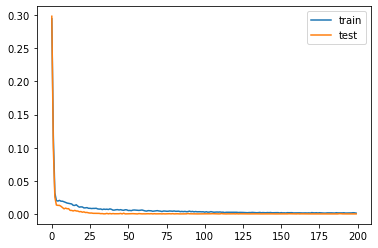

Train RMSE : 0.038
Train R2 : 0.966
Test RMSE : 0.027
Test R2 : 0.968


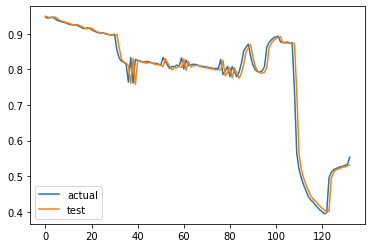

DSBH01_A 스케일러가 저장되었습니다.

DSBH01_A 모델이 저장되었습니다.

======= DSBH02_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
2,0.481557,0.0,0.500000
3,0.500000,0.0,0.522541
4,0.522541,0.0,0.512295
5,0.512295,0.0,0.522541
6,0.522541,0.0,0.522541


train_X : (668, 1, 2) 
train_y : (668,) 
test_X : (168, 1, 2) 
test_y : (168,)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
45/45 - 1s - loss: 0.0928 - acc: 0.0015 - mae: 0.2337 - val_loss: 0.2642 - val_acc: 0.0000e+00 - val_mae: 0.4817
Epoch 2/200
45/45 - 0s - loss: 0.0448 - acc: 0.0015 - mae: 0.1467 - val_loss: 0.1461 - val_acc: 0.0000e+00 - val_m

Epoch 60/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0258 - val_loss: 6.7472e-04 - val_acc: 0.0060 - val_mae: 0.0168
Epoch 61/200
45/45 - 0s - loss: 0.0014 - acc: 0.0015 - mae: 0.0254 - val_loss: 6.0010e-04 - val_acc: 0.0060 - val_mae: 0.0133
Epoch 62/200
45/45 - 0s - loss: 0.0016 - acc: 0.0015 - mae: 0.0269 - val_loss: 6.2555e-04 - val_acc: 0.0060 - val_mae: 0.0128
Epoch 63/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0253 - val_loss: 6.0736e-04 - val_acc: 0.0060 - val_mae: 0.0121
Epoch 64/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0257 - val_loss: 6.1896e-04 - val_acc: 0.0060 - val_mae: 0.0124
Epoch 65/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0242 - val_loss: 6.0226e-04 - val_acc: 0.0060 - val_mae: 0.0126
Epoch 66/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0253 - val_loss: 5.7216e-04 - val_acc: 0.0060 - val_mae: 0.0107
Epoch 67/200
45/45 - 0s - loss: 0.0015 - acc: 0.0015 - mae: 0.0257 - val_loss: 6.3953e-04 - val_acc: 0.0060 - val_mae:

Epoch 124/200
45/45 - 0s - loss: 9.4668e-04 - acc: 0.0015 - mae: 0.0204 - val_loss: 6.2994e-04 - val_acc: 0.0060 - val_mae: 0.0122
Epoch 125/200
45/45 - 0s - loss: 7.9893e-04 - acc: 0.0015 - mae: 0.0192 - val_loss: 5.9495e-04 - val_acc: 0.0060 - val_mae: 0.0134
Epoch 126/200
45/45 - 0s - loss: 0.0011 - acc: 0.0015 - mae: 0.0211 - val_loss: 5.6028e-04 - val_acc: 0.0060 - val_mae: 0.0098
Epoch 127/200
45/45 - 0s - loss: 8.1628e-04 - acc: 0.0015 - mae: 0.0198 - val_loss: 6.8215e-04 - val_acc: 0.0060 - val_mae: 0.0139
Epoch 128/200
45/45 - 0s - loss: 7.9606e-04 - acc: 0.0015 - mae: 0.0196 - val_loss: 5.8638e-04 - val_acc: 0.0060 - val_mae: 0.0123
Epoch 129/200
45/45 - 0s - loss: 9.0003e-04 - acc: 0.0015 - mae: 0.0198 - val_loss: 6.1517e-04 - val_acc: 0.0060 - val_mae: 0.0116
Epoch 130/200
45/45 - 0s - loss: 8.8025e-04 - acc: 0.0015 - mae: 0.0199 - val_loss: 5.4868e-04 - val_acc: 0.0060 - val_mae: 0.0106
Epoch 131/200
45/45 - 0s - loss: 8.1394e-04 - acc: 0.0015 - mae: 0.0196 - val_loss: 5.9

Epoch 187/200
45/45 - 0s - loss: 9.0111e-04 - acc: 0.0015 - mae: 0.0213 - val_loss: 6.2860e-04 - val_acc: 0.0060 - val_mae: 0.0149
Epoch 188/200
45/45 - 0s - loss: 8.0293e-04 - acc: 0.0015 - mae: 0.0190 - val_loss: 5.3903e-04 - val_acc: 0.0060 - val_mae: 0.0092
Epoch 189/200
45/45 - 0s - loss: 8.4858e-04 - acc: 0.0015 - mae: 0.0197 - val_loss: 5.7686e-04 - val_acc: 0.0060 - val_mae: 0.0120
Epoch 190/200
45/45 - 0s - loss: 7.5547e-04 - acc: 0.0015 - mae: 0.0194 - val_loss: 6.7580e-04 - val_acc: 0.0060 - val_mae: 0.0137
Epoch 191/200
45/45 - 0s - loss: 8.4488e-04 - acc: 0.0015 - mae: 0.0198 - val_loss: 5.5287e-04 - val_acc: 0.0060 - val_mae: 0.0090
Epoch 192/200
45/45 - 0s - loss: 9.0473e-04 - acc: 0.0015 - mae: 0.0218 - val_loss: 5.6383e-04 - val_acc: 0.0060 - val_mae: 0.0093
Epoch 193/200
45/45 - 0s - loss: 6.8382e-04 - acc: 0.0015 - mae: 0.0179 - val_loss: 5.5792e-04 - val_acc: 0.0060 - val_mae: 0.0108
Epoch 194/200
45/45 - 0s - loss: 7.8545e-04 - acc: 0.0015 - mae: 0.0200 - val_loss:

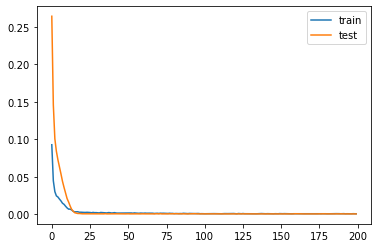

Train RMSE : 0.013
Train R2 : 0.996
Test RMSE : 0.023
Test R2 : 0.986


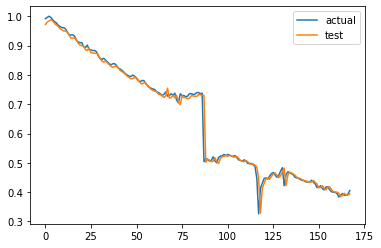

DSBH02_A 스케일러가 저장되었습니다.

DSBH02_A 모델이 저장되었습니다.

======= DSBH03_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.191244,0.0,0.207373
2,0.207373,0.0,0.209678
3,0.209678,0.0,0.205069
4,0.205069,0.0,0.200461
5,0.200461,0.0,0.191244


train_X : (420, 1, 2) 
train_y : (420,) 
test_X : (106, 1, 2) 
test_y : (106,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
28/28 - 1s - loss: 0.0339 - acc: 0.0048 - mae: 0.1556 - val_loss: 0.3215 - val_acc: 0.0000e+00 - val_mae: 0.4744
Epoch 2/200
28/28 - 0s - loss: 0.0143 - acc: 0.0048 - mae: 0.0946 - val_loss: 0.2248 - val_acc: 0.0000e+00 - val_

Epoch 60/200
28/28 - 0s - loss: 5.2605e-04 - acc: 0.0048 - mae: 0.0170 - val_loss: 0.0027 - val_acc: 0.0094 - val_mae: 0.0408
Epoch 61/200
28/28 - 0s - loss: 7.4606e-04 - acc: 0.0048 - mae: 0.0194 - val_loss: 0.0021 - val_acc: 0.0094 - val_mae: 0.0357
Epoch 62/200
28/28 - 0s - loss: 5.6937e-04 - acc: 0.0048 - mae: 0.0174 - val_loss: 0.0021 - val_acc: 0.0094 - val_mae: 0.0358
Epoch 63/200
28/28 - 0s - loss: 5.5038e-04 - acc: 0.0048 - mae: 0.0176 - val_loss: 0.0022 - val_acc: 0.0094 - val_mae: 0.0364
Epoch 64/200
28/28 - 0s - loss: 5.4595e-04 - acc: 0.0048 - mae: 0.0176 - val_loss: 0.0031 - val_acc: 0.0094 - val_mae: 0.0435
Epoch 65/200
28/28 - 0s - loss: 5.4050e-04 - acc: 0.0048 - mae: 0.0167 - val_loss: 0.0024 - val_acc: 0.0094 - val_mae: 0.0388
Epoch 66/200
28/28 - 0s - loss: 5.3169e-04 - acc: 0.0048 - mae: 0.0171 - val_loss: 0.0020 - val_acc: 0.0094 - val_mae: 0.0350
Epoch 67/200
28/28 - 0s - loss: 5.4451e-04 - acc: 0.0048 - mae: 0.0169 - val_loss: 0.0026 - val_acc: 0.0094 - val_mae:

Epoch 125/200
28/28 - 0s - loss: 3.6597e-04 - acc: 0.0048 - mae: 0.0138 - val_loss: 0.0016 - val_acc: 0.0094 - val_mae: 0.0312
Epoch 126/200
28/28 - 0s - loss: 3.1206e-04 - acc: 0.0048 - mae: 0.0128 - val_loss: 0.0016 - val_acc: 0.0094 - val_mae: 0.0314
Epoch 127/200
28/28 - 0s - loss: 3.3068e-04 - acc: 0.0048 - mae: 0.0134 - val_loss: 0.0020 - val_acc: 0.0094 - val_mae: 0.0355
Epoch 128/200
28/28 - 0s - loss: 3.4265e-04 - acc: 0.0048 - mae: 0.0132 - val_loss: 0.0019 - val_acc: 0.0094 - val_mae: 0.0337
Epoch 129/200
28/28 - 0s - loss: 3.8599e-04 - acc: 0.0048 - mae: 0.0148 - val_loss: 0.0029 - val_acc: 0.0094 - val_mae: 0.0416
Epoch 130/200
28/28 - 0s - loss: 3.3367e-04 - acc: 0.0048 - mae: 0.0138 - val_loss: 0.0031 - val_acc: 0.0094 - val_mae: 0.0435
Epoch 131/200
28/28 - 0s - loss: 3.2826e-04 - acc: 0.0048 - mae: 0.0134 - val_loss: 0.0019 - val_acc: 0.0094 - val_mae: 0.0337
Epoch 132/200
28/28 - 0s - loss: 3.4226e-04 - acc: 0.0048 - mae: 0.0139 - val_loss: 0.0024 - val_acc: 0.0094 - 

28/28 - 0s - loss: 3.1086e-04 - acc: 0.0048 - mae: 0.0135 - val_loss: 4.1313e-04 - val_acc: 0.0094 - val_mae: 0.0162
Epoch 190/200
28/28 - 0s - loss: 3.1472e-04 - acc: 0.0048 - mae: 0.0133 - val_loss: 0.0010 - val_acc: 0.0094 - val_mae: 0.0255
Epoch 191/200
28/28 - 0s - loss: 2.8225e-04 - acc: 0.0048 - mae: 0.0128 - val_loss: 4.1514e-04 - val_acc: 0.0094 - val_mae: 0.0163
Epoch 192/200
28/28 - 0s - loss: 3.0735e-04 - acc: 0.0048 - mae: 0.0129 - val_loss: 8.6994e-04 - val_acc: 0.0094 - val_mae: 0.0233
Epoch 193/200
28/28 - 0s - loss: 2.9642e-04 - acc: 0.0048 - mae: 0.0129 - val_loss: 6.8210e-04 - val_acc: 0.0094 - val_mae: 0.0207
Epoch 194/200
28/28 - 0s - loss: 2.9208e-04 - acc: 0.0048 - mae: 0.0128 - val_loss: 0.0010 - val_acc: 0.0094 - val_mae: 0.0251
Epoch 195/200
28/28 - 0s - loss: 2.7974e-04 - acc: 0.0048 - mae: 0.0124 - val_loss: 3.3535e-04 - val_acc: 0.0094 - val_mae: 0.0137
Epoch 196/200
28/28 - 0s - loss: 3.0970e-04 - acc: 0.0048 - mae: 0.0134 - val_loss: 7.6169e-04 - val_acc:

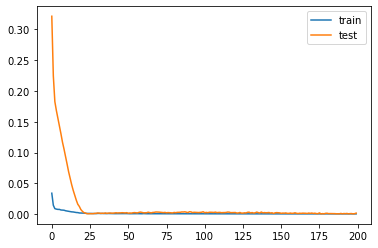

Train RMSE : 0.009
Train R2 : 0.992
Test RMSE : 0.040
Test R2 : 0.988


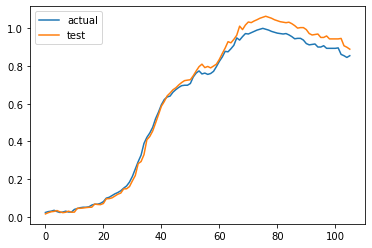

DSBH03_A 스케일러가 저장되었습니다.

DSBH03_A 모델이 저장되었습니다.

======= DSBH04_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
2,0.672489,0.0,0.659389
3,0.659389,0.0,0.566230
4,0.566230,0.0,0.573508
5,0.573508,0.0,0.502183
6,0.502183,0.0,0.480349


train_X : (596, 1, 2) 
train_y : (596,) 
test_X : (149, 1, 2) 
test_y : (149,)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
40/40 - 2s - loss: 0.1273 - acc: 0.0017 - mae: 0.3287 - val_loss: 0.2930 - val_acc: 0.0000e+00 - val_mae: 0.5056
Epoch 2/200
40/40 - 0s - loss: 0.0404 - acc: 0.0017 - mae: 0.1759 - val_loss: 0.1137 - val_acc: 0.0067 - val_mae:

Epoch 60/200
40/40 - 0s - loss: 0.0018 - acc: 0.0017 - mae: 0.0324 - val_loss: 5.4697e-04 - val_acc: 0.0067 - val_mae: 0.0201
Epoch 61/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0317 - val_loss: 3.3808e-04 - val_acc: 0.0067 - val_mae: 0.0160
Epoch 62/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0310 - val_loss: 2.6668e-04 - val_acc: 0.0067 - val_mae: 0.0123
Epoch 63/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0317 - val_loss: 2.8031e-04 - val_acc: 0.0067 - val_mae: 0.0125
Epoch 64/200
40/40 - 0s - loss: 0.0016 - acc: 0.0017 - mae: 0.0307 - val_loss: 2.0254e-04 - val_acc: 0.0067 - val_mae: 0.0104
Epoch 65/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0313 - val_loss: 3.6925e-04 - val_acc: 0.0067 - val_mae: 0.0150
Epoch 66/200
40/40 - 0s - loss: 0.0015 - acc: 0.0017 - mae: 0.0297 - val_loss: 2.6786e-04 - val_acc: 0.0067 - val_mae: 0.0113
Epoch 67/200
40/40 - 0s - loss: 0.0015 - acc: 0.0017 - mae: 0.0296 - val_loss: 2.5712e-04 - val_acc: 0.0067 - val_mae:

Epoch 124/200
40/40 - 0s - loss: 6.7261e-04 - acc: 0.0017 - mae: 0.0175 - val_loss: 1.4735e-04 - val_acc: 0.0067 - val_mae: 0.0094
Epoch 125/200
40/40 - 0s - loss: 7.1039e-04 - acc: 0.0017 - mae: 0.0180 - val_loss: 1.7050e-04 - val_acc: 0.0067 - val_mae: 0.0092
Epoch 126/200
40/40 - 0s - loss: 6.4594e-04 - acc: 0.0017 - mae: 0.0175 - val_loss: 2.5074e-04 - val_acc: 0.0067 - val_mae: 0.0137
Epoch 127/200
40/40 - 0s - loss: 7.1535e-04 - acc: 0.0017 - mae: 0.0189 - val_loss: 1.7543e-04 - val_acc: 0.0067 - val_mae: 0.0110
Epoch 128/200
40/40 - 0s - loss: 7.0998e-04 - acc: 0.0017 - mae: 0.0183 - val_loss: 1.7496e-04 - val_acc: 0.0067 - val_mae: 0.0110
Epoch 129/200
40/40 - 0s - loss: 8.8604e-04 - acc: 0.0017 - mae: 0.0201 - val_loss: 2.6158e-04 - val_acc: 0.0067 - val_mae: 0.0130
Epoch 130/200
40/40 - 0s - loss: 6.0547e-04 - acc: 0.0017 - mae: 0.0171 - val_loss: 1.5702e-04 - val_acc: 0.0067 - val_mae: 0.0088
Epoch 131/200
40/40 - 0s - loss: 7.4081e-04 - acc: 0.0017 - mae: 0.0185 - val_loss:

Epoch 187/200
40/40 - 0s - loss: 6.7734e-04 - acc: 0.0017 - mae: 0.0168 - val_loss: 4.9216e-04 - val_acc: 0.0067 - val_mae: 0.0205
Epoch 188/200
40/40 - 0s - loss: 6.5076e-04 - acc: 0.0017 - mae: 0.0167 - val_loss: 2.2108e-04 - val_acc: 0.0067 - val_mae: 0.0119
Epoch 189/200
40/40 - 0s - loss: 6.5426e-04 - acc: 0.0017 - mae: 0.0166 - val_loss: 3.9862e-04 - val_acc: 0.0067 - val_mae: 0.0184
Epoch 190/200
40/40 - 0s - loss: 7.1681e-04 - acc: 0.0017 - mae: 0.0177 - val_loss: 4.3572e-04 - val_acc: 0.0067 - val_mae: 0.0192
Epoch 191/200
40/40 - 0s - loss: 7.4624e-04 - acc: 0.0017 - mae: 0.0172 - val_loss: 9.2463e-04 - val_acc: 0.0067 - val_mae: 0.0284
Epoch 192/200
40/40 - 0s - loss: 7.4964e-04 - acc: 0.0017 - mae: 0.0180 - val_loss: 1.8926e-04 - val_acc: 0.0067 - val_mae: 0.0113
Epoch 193/200
40/40 - 0s - loss: 6.3853e-04 - acc: 0.0017 - mae: 0.0171 - val_loss: 0.0015 - val_acc: 0.0067 - val_mae: 0.0370
Epoch 194/200
40/40 - 0s - loss: 6.5538e-04 - acc: 0.0017 - mae: 0.0174 - val_loss: 7.6

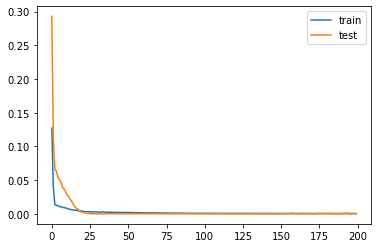

Train RMSE : 0.017
Train R2 : 0.985
Test RMSE : 0.016
Test R2 : 0.995


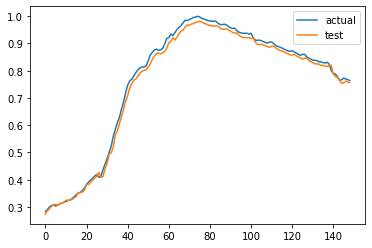

DSBH04_A 스케일러가 저장되었습니다.

DSBH04_A 모델이 저장되었습니다.

======= DSBH01_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.659030,0.0,0.646900
2,0.646900,0.0,0.642857
3,0.642857,0.0,0.642857
4,0.642857,0.0,0.644205
5,0.644205,0.0,0.642857


train_X : (448, 1, 2) 
train_y : (448,) 
test_X : (112, 1, 2) 
test_y : (112,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
30/30 - 1s - loss: 0.3011 - acc: 0.0022 - mae: 0.4982 - val_loss: 0.4228 - val_acc: 0.0000e+00 - val_mae: 0.6380
Epoch 2/200
30/30 - 0s - loss: 0.1623 - acc: 0.0022 - mae: 0.3542 - val_loss: 0.2294 - val_acc: 0.0000e+00 - val_

Epoch 59/200
30/30 - 0s - loss: 0.0049 - acc: 0.0045 - mae: 0.0517 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mae: 0.0192
Epoch 60/200
30/30 - 0s - loss: 0.0056 - acc: 0.0045 - mae: 0.0556 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0116
Epoch 61/200
30/30 - 0s - loss: 0.0052 - acc: 0.0045 - mae: 0.0513 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mae: 0.0275
Epoch 62/200
30/30 - 0s - loss: 0.0048 - acc: 0.0045 - mae: 0.0507 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mae: 0.0180
Epoch 63/200
30/30 - 0s - loss: 0.0060 - acc: 0.0045 - mae: 0.0558 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mae: 0.0199
Epoch 64/200
30/30 - 0s - loss: 0.0049 - acc: 0.0045 - mae: 0.0518 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mae: 0.0167
Epoch 65/200
30/30 - 0s - loss: 0.0044 - acc: 0.0045 - mae: 0.0496 - val_loss: 0.0022 - val_acc: 0.0000e+00 - val_mae: 0.0353
Epoch 66/200
30/30 - 0s - loss: 0.0047 - acc: 0.0045 - mae: 0.0493 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mae:

Epoch 124/200
30/30 - 0s - loss: 0.0027 - acc: 0.0045 - mae: 0.0367 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0111
Epoch 125/200
30/30 - 0s - loss: 0.0025 - acc: 0.0045 - mae: 0.0350 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mae: 0.0239
Epoch 126/200
30/30 - 0s - loss: 0.0026 - acc: 0.0045 - mae: 0.0371 - val_loss: 0.0016 - val_acc: 0.0000e+00 - val_mae: 0.0238
Epoch 127/200
30/30 - 0s - loss: 0.0028 - acc: 0.0045 - mae: 0.0377 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mae: 0.0233
Epoch 128/200
30/30 - 0s - loss: 0.0030 - acc: 0.0045 - mae: 0.0371 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mae: 0.0235
Epoch 129/200
30/30 - 0s - loss: 0.0031 - acc: 0.0045 - mae: 0.0389 - val_loss: 0.0012 - val_acc: 0.0000e+00 - val_mae: 0.0139
Epoch 130/200
30/30 - 0s - loss: 0.0024 - acc: 0.0045 - mae: 0.0343 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mae: 0.0266
Epoch 131/200
30/30 - 0s - loss: 0.0029 - acc: 0.0045 - mae: 0.0378 - val_loss: 0.0012 - val_acc: 0.0000e+00 - 

Epoch 189/200
30/30 - 0s - loss: 0.0017 - acc: 0.0045 - mae: 0.0283 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0105
Epoch 190/200
30/30 - 0s - loss: 0.0017 - acc: 0.0045 - mae: 0.0272 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0123
Epoch 191/200
30/30 - 0s - loss: 0.0012 - acc: 0.0045 - mae: 0.0228 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 192/200
30/30 - 0s - loss: 0.0017 - acc: 0.0045 - mae: 0.0277 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mae: 0.0219
Epoch 193/200
30/30 - 0s - loss: 0.0015 - acc: 0.0045 - mae: 0.0264 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mae: 0.0210
Epoch 194/200
30/30 - 0s - loss: 0.0015 - acc: 0.0045 - mae: 0.0257 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mae: 0.0269
Epoch 195/200
30/30 - 0s - loss: 0.0022 - acc: 0.0045 - mae: 0.0331 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_mae: 0.0198
Epoch 196/200
30/30 - 0s - loss: 0.0016 - acc: 0.0045 - mae: 0.0272 - val_loss: 0.0013 - val_acc: 0.0000e+00 - 

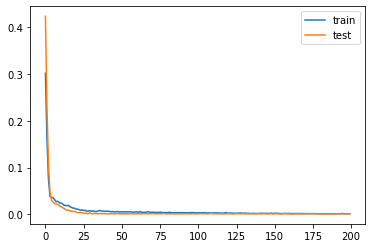

Train RMSE : 0.020
Train R2 : 0.994
Test RMSE : 0.038
Test R2 : 0.918


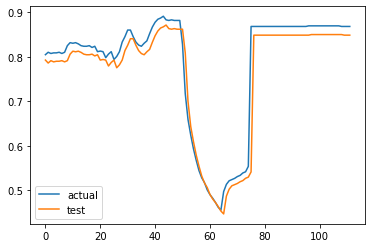

DSBH01_B 스케일러가 저장되었습니다.

DSBH01_B 모델이 저장되었습니다.

======= DSBH02_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
2,0.554217,0.0,0.556225
3,0.556225,0.0,0.574297
4,0.574297,0.0,0.572289
5,0.572289,0.0,0.572289
6,0.572289,0.0,0.568273


train_X : (668, 1, 2) 
train_y : (668,) 
test_X : (168, 1, 2) 
test_y : (168,)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
45/45 - 1s - loss: 0.0830 - acc: 0.0045 - mae: 0.2088 - val_loss: 0.2665 - val_acc: 0.0000e+00 - val_mae: 0.4869
Epoch 2/200
45/45 - 0s - loss: 0.0410 - acc: 0.0045 - mae: 0.1408 - val_loss: 0.1523 - val_acc: 0.0000e+00 - val_

Epoch 60/200
45/45 - 0s - loss: 0.0013 - acc: 0.0045 - mae: 0.0232 - val_loss: 4.2488e-04 - val_acc: 0.0060 - val_mae: 0.0109
Epoch 61/200
45/45 - 0s - loss: 0.0013 - acc: 0.0045 - mae: 0.0246 - val_loss: 4.2909e-04 - val_acc: 0.0060 - val_mae: 0.0114
Epoch 62/200
45/45 - 0s - loss: 0.0012 - acc: 0.0045 - mae: 0.0232 - val_loss: 4.6318e-04 - val_acc: 0.0060 - val_mae: 0.0119
Epoch 63/200
45/45 - 0s - loss: 0.0012 - acc: 0.0045 - mae: 0.0225 - val_loss: 4.5703e-04 - val_acc: 0.0060 - val_mae: 0.0126
Epoch 64/200
45/45 - 0s - loss: 0.0013 - acc: 0.0045 - mae: 0.0243 - val_loss: 4.1466e-04 - val_acc: 0.0060 - val_mae: 0.0107
Epoch 65/200
45/45 - 0s - loss: 0.0015 - acc: 0.0045 - mae: 0.0242 - val_loss: 4.5899e-04 - val_acc: 0.0060 - val_mae: 0.0115
Epoch 66/200
45/45 - 0s - loss: 0.0012 - acc: 0.0045 - mae: 0.0226 - val_loss: 4.4201e-04 - val_acc: 0.0060 - val_mae: 0.0109
Epoch 67/200
45/45 - 0s - loss: 0.0012 - acc: 0.0045 - mae: 0.0234 - val_loss: 4.5212e-04 - val_acc: 0.0060 - val_mae:

Epoch 124/200
45/45 - 0s - loss: 8.3037e-04 - acc: 0.0045 - mae: 0.0190 - val_loss: 3.6709e-04 - val_acc: 0.0060 - val_mae: 0.0080
Epoch 125/200
45/45 - 0s - loss: 9.2677e-04 - acc: 0.0045 - mae: 0.0214 - val_loss: 4.0919e-04 - val_acc: 0.0060 - val_mae: 0.0108
Epoch 126/200
45/45 - 0s - loss: 9.3499e-04 - acc: 0.0045 - mae: 0.0201 - val_loss: 4.1515e-04 - val_acc: 0.0060 - val_mae: 0.0090
Epoch 127/200
45/45 - 0s - loss: 8.4588e-04 - acc: 0.0045 - mae: 0.0198 - val_loss: 3.7646e-04 - val_acc: 0.0060 - val_mae: 0.0078
Epoch 128/200
45/45 - 0s - loss: 8.0569e-04 - acc: 0.0045 - mae: 0.0187 - val_loss: 3.6057e-04 - val_acc: 0.0060 - val_mae: 0.0069
Epoch 129/200
45/45 - 0s - loss: 8.9176e-04 - acc: 0.0045 - mae: 0.0209 - val_loss: 3.6717e-04 - val_acc: 0.0060 - val_mae: 0.0071
Epoch 130/200
45/45 - 0s - loss: 8.5380e-04 - acc: 0.0045 - mae: 0.0196 - val_loss: 3.8387e-04 - val_acc: 0.0060 - val_mae: 0.0077
Epoch 131/200
45/45 - 0s - loss: 8.5833e-04 - acc: 0.0045 - mae: 0.0196 - val_loss:

Epoch 187/200
45/45 - 0s - loss: 7.1784e-04 - acc: 0.0045 - mae: 0.0192 - val_loss: 3.6560e-04 - val_acc: 0.0060 - val_mae: 0.0072
Epoch 188/200
45/45 - 0s - loss: 8.9315e-04 - acc: 0.0045 - mae: 0.0215 - val_loss: 3.7841e-04 - val_acc: 0.0060 - val_mae: 0.0075
Epoch 189/200
45/45 - 0s - loss: 7.3555e-04 - acc: 0.0045 - mae: 0.0192 - val_loss: 3.7082e-04 - val_acc: 0.0060 - val_mae: 0.0071
Epoch 190/200
45/45 - 0s - loss: 7.7426e-04 - acc: 0.0045 - mae: 0.0193 - val_loss: 4.0392e-04 - val_acc: 0.0060 - val_mae: 0.0107
Epoch 191/200
45/45 - 0s - loss: 8.5677e-04 - acc: 0.0045 - mae: 0.0209 - val_loss: 3.5851e-04 - val_acc: 0.0060 - val_mae: 0.0067
Epoch 192/200
45/45 - 0s - loss: 8.6486e-04 - acc: 0.0045 - mae: 0.0194 - val_loss: 4.2497e-04 - val_acc: 0.0060 - val_mae: 0.0093
Epoch 193/200
45/45 - 0s - loss: 8.7334e-04 - acc: 0.0045 - mae: 0.0203 - val_loss: 3.6936e-04 - val_acc: 0.0060 - val_mae: 0.0079
Epoch 194/200
45/45 - 0s - loss: 9.4227e-04 - acc: 0.0045 - mae: 0.0204 - val_loss:

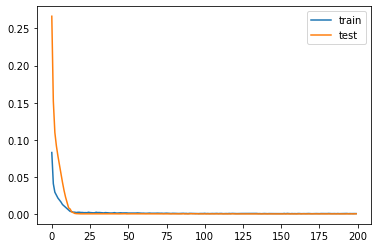

Train RMSE : 0.012
Train R2 : 0.996
Test RMSE : 0.023
Test R2 : 0.985


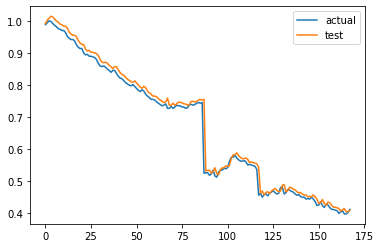

DSBH02_B 스케일러가 저장되었습니다.

DSBH02_B 모델이 저장되었습니다.

======= DSBH03_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.120087,0.0,0.135371
2,0.135371,0.0,0.133188
3,0.133188,0.0,0.126637
4,0.126637,0.0,0.120087
5,0.120087,0.0,0.113537


train_X : (512, 1, 2) 
train_y : (512,) 
test_X : (128, 1, 2) 
test_y : (128,)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
35/35 - 1s - loss: 0.1223 - acc: 0.0020 - mae: 0.2676 - val_loss: 0.1900 - val_acc: 0.0000e+00 - val_mae: 0.3158
Epoch 2/200
35/35 - 0s - loss: 0.0646 - acc: 0.0020 - mae: 0.1785 - val_loss: 0.1201 - val_acc: 0.0000e+00 - val_

Epoch 59/200
35/35 - 0s - loss: 0.0032 - acc: 0.0039 - mae: 0.0342 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0159
Epoch 60/200
35/35 - 0s - loss: 0.0028 - acc: 0.0039 - mae: 0.0352 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0190
Epoch 61/200
35/35 - 0s - loss: 0.0022 - acc: 0.0039 - mae: 0.0327 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0161
Epoch 62/200
35/35 - 0s - loss: 0.0032 - acc: 0.0039 - mae: 0.0360 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0136
Epoch 63/200
35/35 - 0s - loss: 0.0030 - acc: 0.0039 - mae: 0.0342 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0134
Epoch 64/200
35/35 - 0s - loss: 0.0030 - acc: 0.0039 - mae: 0.0358 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0132
Epoch 65/200
35/35 - 0s - loss: 0.0028 - acc: 0.0039 - mae: 0.0341 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0150
Epoch 66/200
35/35 - 0s - loss: 0.0026 - acc: 0.0039 - mae: 0.0332 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae:

Epoch 124/200
35/35 - 0s - loss: 0.0015 - acc: 0.0039 - mae: 0.0262 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0164
Epoch 125/200
35/35 - 0s - loss: 0.0014 - acc: 0.0039 - mae: 0.0247 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0129
Epoch 126/200
35/35 - 0s - loss: 0.0018 - acc: 0.0039 - mae: 0.0252 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0127
Epoch 127/200
35/35 - 0s - loss: 0.0016 - acc: 0.0039 - mae: 0.0255 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0131
Epoch 128/200
35/35 - 0s - loss: 0.0017 - acc: 0.0039 - mae: 0.0271 - val_loss: 0.0032 - val_acc: 0.0000e+00 - val_mae: 0.0161
Epoch 129/200
35/35 - 0s - loss: 0.0015 - acc: 0.0039 - mae: 0.0247 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0130
Epoch 130/200
35/35 - 0s - loss: 0.0014 - acc: 0.0039 - mae: 0.0256 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0143
Epoch 131/200
35/35 - 0s - loss: 0.0016 - acc: 0.0039 - mae: 0.0268 - val_loss: 0.0031 - val_acc: 0.0000e+00 - 

Epoch 189/200
35/35 - 0s - loss: 0.0011 - acc: 0.0039 - mae: 0.0212 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0177
Epoch 190/200
35/35 - 0s - loss: 0.0012 - acc: 0.0039 - mae: 0.0248 - val_loss: 0.0032 - val_acc: 0.0000e+00 - val_mae: 0.0201
Epoch 191/200
35/35 - 0s - loss: 0.0011 - acc: 0.0039 - mae: 0.0228 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0135
Epoch 192/200
35/35 - 0s - loss: 0.0012 - acc: 0.0039 - mae: 0.0227 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0125
Epoch 193/200
35/35 - 0s - loss: 0.0014 - acc: 0.0039 - mae: 0.0231 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0131
Epoch 194/200
35/35 - 0s - loss: 0.0014 - acc: 0.0039 - mae: 0.0229 - val_loss: 0.0032 - val_acc: 0.0000e+00 - val_mae: 0.0148
Epoch 195/200
35/35 - 0s - loss: 0.0013 - acc: 0.0039 - mae: 0.0238 - val_loss: 0.0033 - val_acc: 0.0000e+00 - val_mae: 0.0162
Epoch 196/200
35/35 - 0s - loss: 0.0012 - acc: 0.0039 - mae: 0.0225 - val_loss: 0.0030 - val_acc: 0.0000e+00 - 

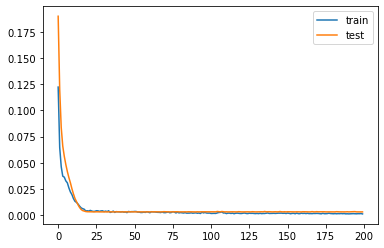

Train RMSE : 0.014
Train R2 : 0.997
Test RMSE : 0.055
Test R2 : 0.972


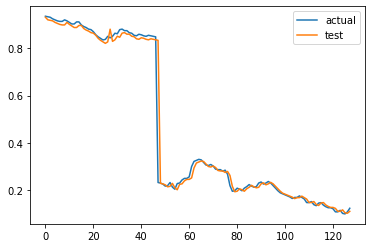

DSBH03_B 스케일러가 저장되었습니다.

DSBH03_B 모델이 저장되었습니다.

======= DSBH04_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
2,0.915857,0.0,0.919094
3,0.919094,0.0,0.951455
4,0.951455,0.0,0.941748
5,0.941748,0.0,0.938511
6,0.938511,0.0,0.932038


train_X : (498, 1, 2) 
train_y : (498,) 
test_X : (125, 1, 2) 
test_y : (125,)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 60)                15120     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
34/34 - 1s - loss: 0.1822 - acc: 0.0020 - mae: 0.3350 - val_loss: 0.0215 - val_acc: 0.0000e+00 - val_mae: 0.1300
Epoch 2/200
34/34 - 0s - loss: 0.1097 - acc: 0.0020 - mae: 0.2405 - val_loss: 0.0050 - val_acc: 0.0000e+00 - val_

Epoch 58/200
34/34 - 0s - loss: 0.0035 - acc: 0.0040 - mae: 0.0403 - val_loss: 1.6596e-04 - val_acc: 0.0000e+00 - val_mae: 0.0103
Epoch 59/200
34/34 - 0s - loss: 0.0035 - acc: 0.0040 - mae: 0.0405 - val_loss: 1.6065e-04 - val_acc: 0.0000e+00 - val_mae: 0.0103
Epoch 60/200
34/34 - 0s - loss: 0.0036 - acc: 0.0040 - mae: 0.0410 - val_loss: 1.6526e-04 - val_acc: 0.0000e+00 - val_mae: 0.0106
Epoch 61/200
34/34 - 0s - loss: 0.0034 - acc: 0.0040 - mae: 0.0394 - val_loss: 1.6891e-04 - val_acc: 0.0000e+00 - val_mae: 0.0106
Epoch 62/200
34/34 - 0s - loss: 0.0042 - acc: 0.0040 - mae: 0.0430 - val_loss: 1.8819e-04 - val_acc: 0.0000e+00 - val_mae: 0.0111
Epoch 63/200
34/34 - 0s - loss: 0.0032 - acc: 0.0040 - mae: 0.0388 - val_loss: 1.8270e-04 - val_acc: 0.0000e+00 - val_mae: 0.0113
Epoch 64/200
34/34 - 0s - loss: 0.0029 - acc: 0.0040 - mae: 0.0389 - val_loss: 1.5456e-04 - val_acc: 0.0000e+00 - val_mae: 0.0102
Epoch 65/200
34/34 - 0s - loss: 0.0037 - acc: 0.0040 - mae: 0.0422 - val_loss: 1.4948e-04 

Epoch 121/200
34/34 - 0s - loss: 0.0023 - acc: 0.0040 - mae: 0.0344 - val_loss: 3.2748e-04 - val_acc: 0.0000e+00 - val_mae: 0.0147
Epoch 122/200
34/34 - 0s - loss: 0.0024 - acc: 0.0040 - mae: 0.0325 - val_loss: 1.3124e-04 - val_acc: 0.0000e+00 - val_mae: 0.0093
Epoch 123/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0297 - val_loss: 1.7695e-04 - val_acc: 0.0000e+00 - val_mae: 0.0107
Epoch 124/200
34/34 - 0s - loss: 0.0023 - acc: 0.0040 - mae: 0.0321 - val_loss: 2.5137e-04 - val_acc: 0.0000e+00 - val_mae: 0.0127
Epoch 125/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0294 - val_loss: 1.5437e-04 - val_acc: 0.0000e+00 - val_mae: 0.0101
Epoch 126/200
34/34 - 0s - loss: 0.0020 - acc: 0.0040 - mae: 0.0312 - val_loss: 2.0336e-04 - val_acc: 0.0000e+00 - val_mae: 0.0115
Epoch 127/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0311 - val_loss: 1.6688e-04 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 128/200
34/34 - 0s - loss: 0.0018 - acc: 0.0040 - mae: 0.0300 - val_loss: 1.1

Epoch 184/200
34/34 - 0s - loss: 0.0016 - acc: 0.0040 - mae: 0.0279 - val_loss: 1.0205e-04 - val_acc: 0.0000e+00 - val_mae: 0.0081
Epoch 185/200
34/34 - 0s - loss: 0.0018 - acc: 0.0040 - mae: 0.0270 - val_loss: 1.2219e-04 - val_acc: 0.0000e+00 - val_mae: 0.0089
Epoch 186/200
34/34 - 0s - loss: 0.0014 - acc: 0.0040 - mae: 0.0263 - val_loss: 1.9778e-04 - val_acc: 0.0000e+00 - val_mae: 0.0114
Epoch 187/200
34/34 - 0s - loss: 0.0016 - acc: 0.0040 - mae: 0.0277 - val_loss: 1.2269e-04 - val_acc: 0.0000e+00 - val_mae: 0.0090
Epoch 188/200
34/34 - 0s - loss: 0.0013 - acc: 0.0040 - mae: 0.0252 - val_loss: 1.6888e-04 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 189/200
34/34 - 0s - loss: 0.0015 - acc: 0.0040 - mae: 0.0261 - val_loss: 1.0935e-04 - val_acc: 0.0000e+00 - val_mae: 0.0084
Epoch 190/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0286 - val_loss: 1.4161e-04 - val_acc: 0.0000e+00 - val_mae: 0.0096
Epoch 191/200
34/34 - 0s - loss: 0.0014 - acc: 0.0040 - mae: 0.0266 - val_loss: 1.1

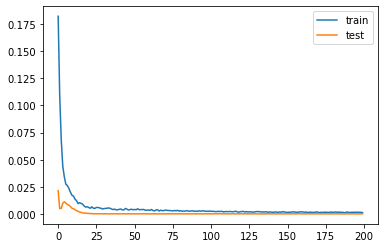

Train RMSE : 0.018
Train R2 : 0.996
Test RMSE : 0.014
Test R2 : 0.971


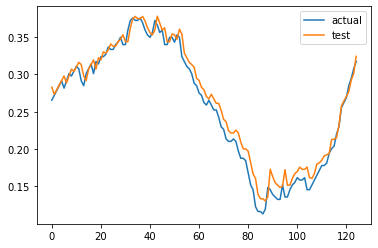

DSBH04_B 스케일러가 저장되었습니다.

DSBH04_B 모델이 저장되었습니다.



In [ ]:
start(0)

CSV File has been created


'df'

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


'_df'

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.37,NaN,26.04,NaN,29.76,NaN,29.86,NaN
2018-11-14,NaN,29.45,NaN,26.03,NaN,29.75,NaN,29.86,0.0
2018-11-15,NaN,29.54,NaN,25.94,NaN,29.76,NaN,29.87,0.0
2018-11-16,NaN,29.65,NaN,25.30,NaN,29.85,NaN,29.97,0.0
2018-11-17,NaN,29.60,NaN,25.35,NaN,29.84,NaN,29.94,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-26,NaN,NaN,NaN,NaN,27.44,NaN,NaN,NaN,NaN
2021-08-27,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,27.43,NaN,NaN,NaN,NaN


DSBH01_A
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                15120     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


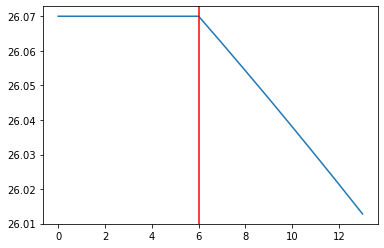

DSBH02_A
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


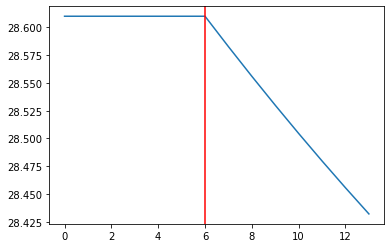

DSBH03_A
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


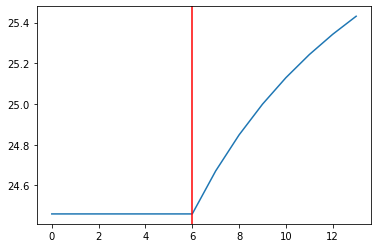

DSBH04_A
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


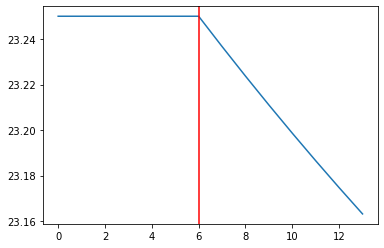

DSBH01_B
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


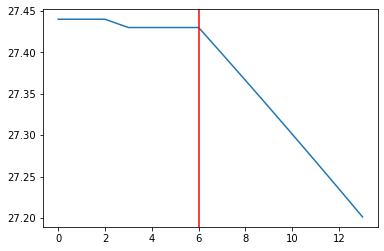

DSBH02_B
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


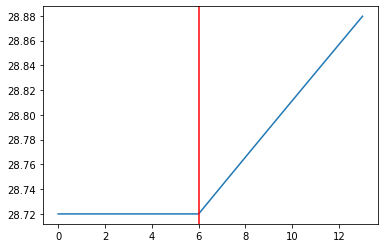

DSBH03_B
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


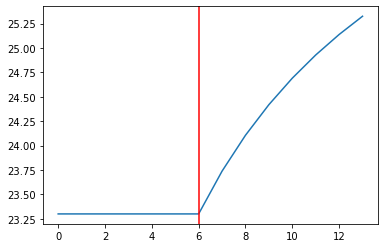

DSBH04_B
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


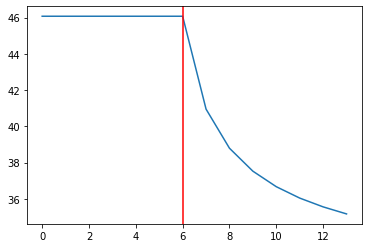

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B
2021-08-31,26.062166,28.582649,24.671150,23.236706,27.398249,28.742990,23.738321,40.948505
2021-09-01,26.054218,28.555944,24.848299,23.223713,27.366180,28.765903,24.105839,38.792355
2021-09-02,26.046164,28.529886,24.999203,23.211025,27.333796,28.788748,24.419455,37.526905
2021-09-03,26.037994,28.504471,25.129381,23.198629,27.301104,28.811535,24.690861,36.671101
2021-09-04,26.029715,28.479696,25.242867,23.186523,27.268105,28.834274,24.928444,36.043694
2021-09-05,26.021320,28.455557,25.342697,23.174706,27.234806,28.856979,25.138409,35.558941
2021-09-06,26.012815,28.432053,25.431194,23.163166,27.201214,28.879654,25.325453,35.170303


CSV is saved
DB Inserted
Process is finished


In [ ]:
start(1)

In [ ]:
if '_B' in 'DSBH01_A':
    print('a')